## D(St)reams of Anomalies
  The real world does not slow down for bad data
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the benchmark data set from
https://www.kaggle.com/boltzmannbrain/nab or
https://github.com/numenta/NAB/tree/master/data
3. Load the one of the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more anomaly detection models to determine the anomalies using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

**The dataset taken is the timeseries data with the ambient temperatures settings in an office. The goal is to find the anomlalies in the temperature values set in the environment. The temperature may vary from place to place and season to season. In the dataset, the location is same and the temperature values are given from July 2013 to May 2014.**

In [2]:
ambTempDf = pd.read_csv('../data/ambient_temperature_system_failure.txt')
ambTempDf.head(5)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [3]:
ambTempDf.columns

Index(['timestamp', 'value'], dtype='object')

**Since the timestamp is an object type, it is to be converted to the the datetime object for further requirements.**

In [4]:
ambTempDf['timestamp'] = pd.to_datetime(ambTempDf['timestamp'])

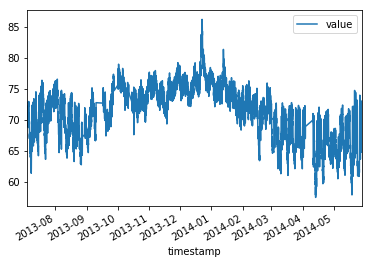

In [5]:
ambTempDf.plot(x='timestamp',y='value')
plt.show()

**The above graph shows the distribution of the temperature given the timestamp.**

**Lets apply some of the statistical methods to detect the probable outliers without considering the timestamps.**

## Standard Deviation Method

**In this method, the mean and standard deviataion are calculated and by using upper and lower threshold boundary, the data is filtered.**

In [6]:
mean = ambTempDf.value.mean()
stdDev = ambTempDf.value.std()
print('minimum value : {}'.format(ambTempDf['value'].min()))
print('maximum value : {}'.format(ambTempDf['value'].max()))
print('mean : {}'.format(mean))
print('standard deviation : {}'.format(stdDev))

minimum value : 57.45840559
maximum value : 86.22321261
mean : 71.2424327082882
standard deviation : 4.247509415248352


In [7]:
cut_off = stdDev * 3
lower, upper = mean - cut_off, mean + cut_off
print('lower boundary : {}, upper boundary : {}'.format(lower,upper))

lower boundary : 58.49990446254315, upper boundary : 83.98496095403326


**The cutoff is taken as three times the standard deviation and lower and upper boundary is obtained by adding to and subtracting the cut off from mean respectively. Now, the anomaly can be filtered.**

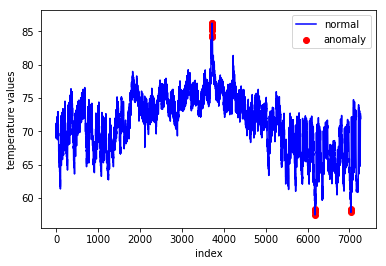

In [8]:
anomaly = ambTempDf.loc[(ambTempDf['value']<lower)|(ambTempDf['value']>upper), ['timestamp','value']]
plt.plot(ambTempDf.index,ambTempDf['value'],color='blue',label='normal')
plt.scatter(anomaly.index,anomaly['value'].values,color='red',label='anomaly')
plt.xlabel('index')
plt.ylabel('temperature values')
plt.legend()
plt.show()

**The above graph shows the red dots as the anomaly values. According to this method, the values that are around the minumum and maximum are considered as the outliers which may or may not be true in all cases.**

**The another statistical method applied is Interquartile range. In this method, the $25^{th}$ and $75^{th}$ percentiles are calculated and the difference obtained is taken to compute the upper and lower boundary.** 

## Interquartile range

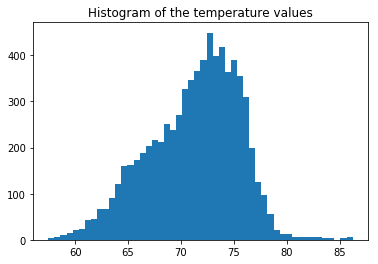

In [9]:
plt.hist(ambTempDf['value'],bins=50)
plt.title('Histogram of the temperature values')
plt.show()

quartile25: 68.36941051 ,quartile75: 74.43095786
inter quartile range: 6.061547350000012
lower: 59.277089484999976, upper: 83.52327888500002


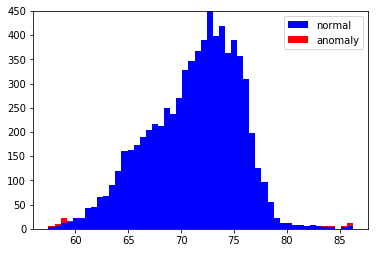

In [10]:
quartile25,quartile75 = np.percentile(ambTempDf.value,25), np.percentile(ambTempDf.value,75)
print('quartile25: {} ,quartile75: {}'.format(quartile25,quartile75))
interRange = quartile75-quartile25
print('inter quartile range: {}'.format(interRange))
cutOff = 1.5*interRange
lower,upper = quartile25-cutOff , quartile75+cutOff
print('lower: {}, upper: {}'.format(lower,upper))
anomaly1 = ambTempDf.loc[(ambTempDf['value']<lower)|(ambTempDf['value']>upper), ['timestamp','value']]
plt.hist([ambTempDf['value'],anomaly1['value']],color=['blue', 'red'],bins=50,stacked=True,label=['normal','anomaly'])
plt.legend()
plt.show()

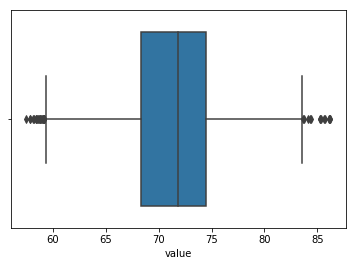

In [11]:
ax = sns.boxplot(x=ambTempDf['value'])

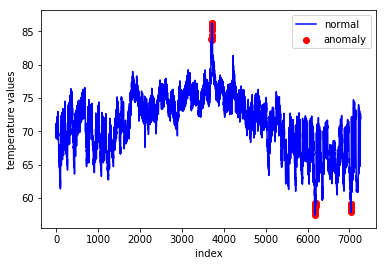

In [12]:
plt.plot(ambTempDf.index,ambTempDf['value'],color='blue',label='normal')
plt.scatter(anomaly1.index,anomaly1['value'].values,color='red',label='anomaly')
plt.xlabel('index')
plt.ylabel('temperature values')
plt.legend()
plt.show()

**The obtained plots show the similar result as that was obtained from the standard deviation method. Since, we have not taken any consideration such as day and night cases, weekdays or weekends about the timestamp, we cannot be sure that the anomaly detected by using the values only are accurate.**

**Now we will use isolation forest and consider the timestamp as well to detect the anomaly in the data.**

## Isolation Forest

**From the timestamp, we can extract the features such as seasons, working hours, week days and weekends which might be helpful for anomaly prediction. for eg: In weekends, the office may be closed and the temperature system may operate differently.  

In [13]:
ambTempDf['fall'] = (ambTempDf['timestamp'].dt.month).isin([9,10,11]).astype(int)
ambTempDf['spring'] = (ambTempDf['timestamp'].dt.month).isin([3,4,5]).astype(int)
ambTempDf['summer'] = (ambTempDf['timestamp'].dt.month).isin([6,7,8]).astype(int)
ambTempDf['winter'] = (ambTempDf['timestamp'].dt.month).isin([12,1,2]).astype(int)
ambTempDf['hours'] = ambTempDf['timestamp'].dt.hour
ambTempDf['dayLight'] = ((ambTempDf['hours'] >= 7) & (ambTempDf['hours'] <= 22)).astype(int)
ambTempDf['dayOfTheWeek'] = ambTempDf['timestamp'].dt.dayofweek
ambTempDf['weekDay'] = (ambTempDf['dayOfTheWeek'] < 5).astype(int)
ambTempDf.head(5)

,timestamp,value,fall,spring,summer,winter,hours,dayLight,dayOfTheWeek,weekDay
0,2013-07-04 00:00:00,69.880835,0,0,1,0,0,0,3,1
1,2013-07-04 01:00:00,71.220227,0,0,1,0,1,0,3,1
2,2013-07-04 02:00:00,70.877805,0,0,1,0,2,0,3,1
3,2013-07-04 03:00:00,68.959400,0,0,1,0,3,0,3,1
4,2013-07-04 04:00:00,69.283551,0,0,1,0,4,0,3,1


**The above table shows the features extracted for the prediction.**

**Lets train the isolation forest model with the extracted features.**

In [14]:
outlierFrac = 0.01
data = ambTempDf[['value','hours','dayLight','dayOfTheWeek','weekDay','fall','spring','summer','winter']]
scaler=StandardScaler()
npScaled = scaler.fit_transform(data)
dataFrame = pd.DataFrame(npScaled)
model = IsolationForest(contamination=outlierFrac)
model.fit(dataFrame)
ambTempDf['anomaly2'] = pd.Series(model.predict(dataFrame))
a = ambTempDf.loc[ambTempDf['anomaly2'] == -1, ['timestamp', 'value']]

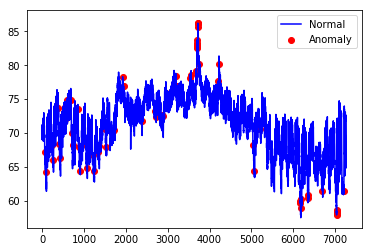

In [15]:
plt.plot(ambTempDf.index, ambTempDf['value'], color='blue', label = 'Normal')
plt.scatter(a.index,a['value'],color='red', label = 'Anomaly')
plt.legend()
plt.show()

**Unlike the results of statistical methods performed above, the result of this model shows the anomalies other than the outliers. We can segregate the features and find the cause for the anomaly.** 

In [16]:
anomalies = ambTempDf[ambTempDf['anomaly2'] ==-1]
print('count: {}'.format(anomalies.shape[0]))


count: 73


In [17]:
anomalies[['fall','spring','summer','winter']].sum()

fall      18
spring    12
summer    22
winter    21
dtype: int64

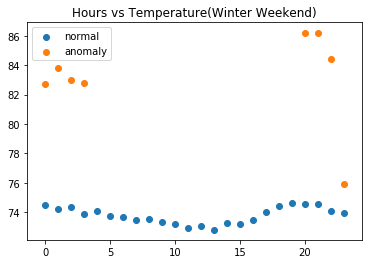

In [18]:
normalWinter = ambTempDf[(ambTempDf['winter']==1) & (ambTempDf['anomaly2']==1) &(ambTempDf['weekDay']==0)] \
.groupby('hours')['value'].agg(['count','mean']).reset_index()
anomalyWinter = anomalies[(anomalies['winter']==1) & (anomalies['anomaly2']==-1) &(anomalies['weekDay']==0)].\
groupby('hours')['value'].agg(['count','mean']).reset_index()
plt.scatter(normalWinter['hours'], normalWinter['mean'],label='normal')
plt.scatter(anomalyWinter.hours, anomalyWinter['mean'],label='anomaly')
plt.title('Hours vs Temperature(Winter Weekend)')
plt.legend()
plt.show()

**The algorithm seems to consider the temperature significantly above the average as the anomaly for the particular hour, winter season and weekend as shown in the figure above. Here the isolation tree considers combination of more than one features to isolate such anomalies.**

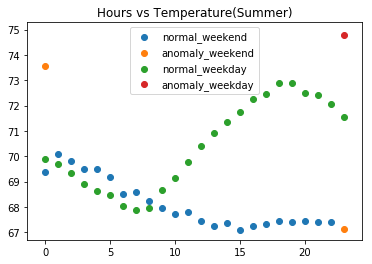

In [19]:
normalSummerWeekEnd = ambTempDf[(ambTempDf['summer']==1) & (ambTempDf['anomaly2']==1) &(ambTempDf['weekDay']==0)] \
.groupby('hours')['value'].agg(['count','mean']).reset_index()
anomalySummerWeekEnd = anomalies[(anomalies['summer']==1) & (anomalies['anomaly2']==-1) &(anomalies['weekDay']==0)].\
groupby('hours')['value'].agg(['count','mean']).reset_index()
plt.scatter(normalSummerWeekEnd['hours'], normalSummerWeekEnd['mean'],label='normal_weekend')
plt.scatter(anomalySummerWeekEnd.hours, anomalySummerWeekEnd['mean'],label='anomaly_weekend')


normalSummerWeekDay = ambTempDf[(ambTempDf['summer']==1) & (ambTempDf['anomaly2']==1) &(ambTempDf['weekDay']==1)] \
.groupby('hours')['value'].agg(['count','mean']).reset_index()
anomalySummerWeekDay = anomalies[(anomalies['summer']==1) & (anomalies['anomaly2']==-1) &(anomalies['weekDay']==1)].\
groupby('hours')['value'].agg(['count','mean']).reset_index()

plt.scatter(normalSummerWeekDay['hours'], normalSummerWeekDay['mean'],label='normal_weekday')
plt.scatter(anomalySummerWeekDay.hours, anomalySummerWeekDay['mean'],label='anomaly_weekday')


plt.title('Hours vs Temperature(Summer)')
plt.legend()
plt.show()

**It can be observed from the figure above that the ambient temperature increases in the weekdays between office hours and starts to decrease after office hours. However, in weekends, the ambient temperature decreases normally. Isolation forest has successfully caputered this phenomenon and didnot catagorize the pattern change as the anomaly. The outliers from the patterns are caputured as anomalies. Since this method is unsupervised learning, there may be some fallacies. For example, the mean temperature for hour 23 for winter weekend is catagorized anomaly although it seems to be normal.**